---
# 1D Normalization profile

In [1]:
from linescanning import (
    utils,
    prf,
    plotting
)
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import os
opj = os.path.join


In [2]:
subject = "sub-003"
vert_file = f"/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/pycortex/{subject}/line_pycortex.csv"
vert_info = utils.VertexInfo(vert_file, subject=subject)
targ_vertex = vert_info.get("index")["lh"]
targ_vertex


835

In [3]:
prf_dir = "/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/prf"
ses = 1
subj_prf = opj(prf_dir, subject, f"ses-{ses}")
data = np.load(opj(subj_prf, f"{subject}_ses-1_task-2R_hemi-LR_desc-avg_bold.npy"))
dm = prf.read_par_file(opj(subj_prf, "design_task-2R.mat"))
data.shape


(116, 314134)

Design has 4 more volumes than timecourses, trimming from beginning of design to (250, 250, 116)
Reading settings from '/data1/projects/MicroFunc/Jurjen/programs/packages/linescanning/misc/prf_analysis.yml'
Instantiate HRF with: [1, 4.6, 0] (fit=False)
Using constraint(s): ['tc', 'tc']
Reading settings from '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/prf/sub-003/ses-1/sub-003_ses-1_task-2R_model-norm_stage-iter_desc-prf_params.pkl' (safest option; overwrites other settings)
Inserting parameters from <class 'str'> as 'norm_iter' in <linescanning.prf.pRFmodelFitting object at 0x7fa770943370>


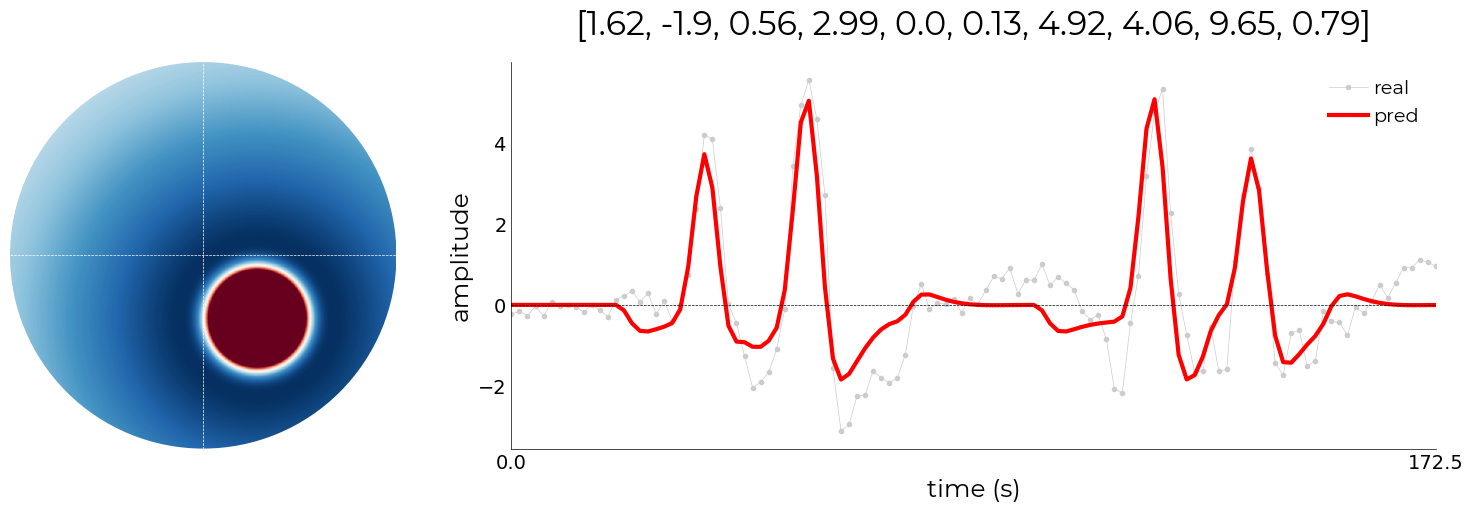

In [4]:
%matplotlib inline
obj = prf.pRFmodelFitting(
    data.T,
    design_matrix=dm,
    TR=1.5,
    verbose=True,
    model="norm"
)

par_file = opj(subj_prf, f"{subject}_ses-{ses}_task-2R_model-norm_stage-iter_desc-prf_params.pkl")
obj.load_params(par_file, model="norm")

pars,_,tc,pred = obj.plot_vox(vox_nr=targ_vertex, title="pars", model="norm")


AUC = 0.0


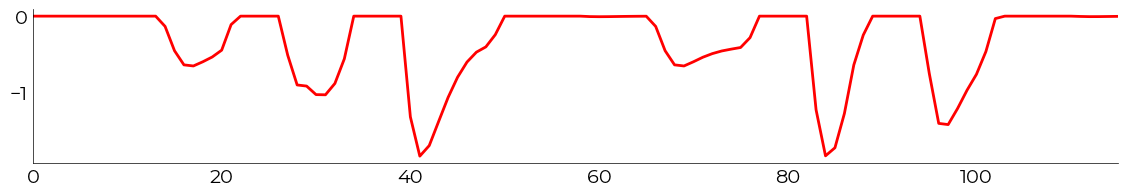

In [5]:
pred_neg = np.zeros_like(pred)
pred_neg[pred<0] = pred[pred<0]

dx = obj.TR
X = np.arange(0,pred_neg.shape[0])
# Y = pred_neg.squeeze()
Y = np.zeros_like(pred_neg).squeeze()
suppr_auc = abs(np.trapz(Y, dx=dx))
print(f"AUC = {round(suppr_auc,2)}")
plotting.LazyPlot(
    pred_neg,
    figsize=(14,2),
    line_width=2,
    color="r"
)


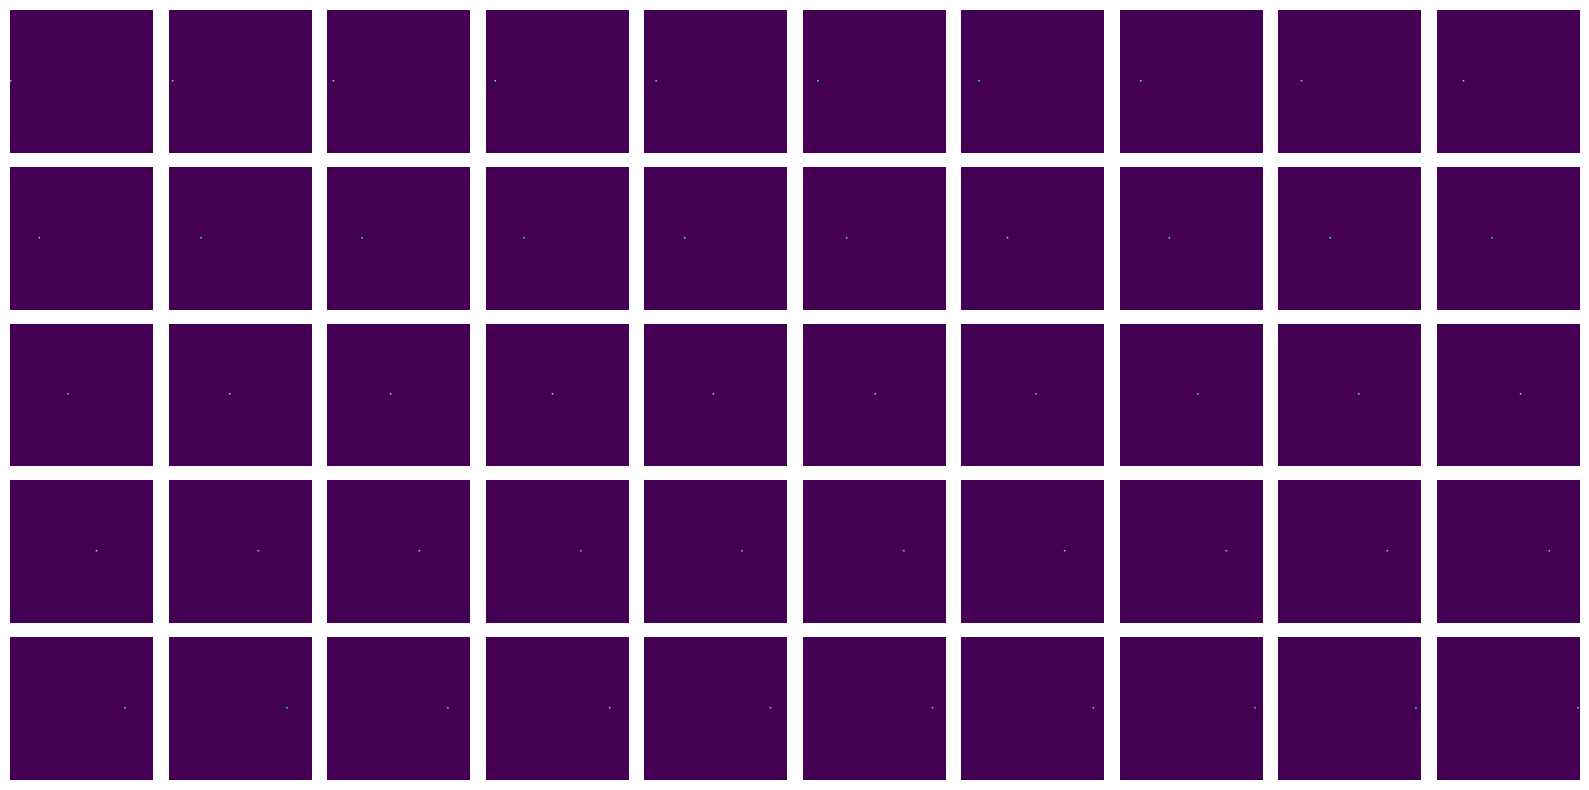

In [6]:
# create impulse design matrix (single pixel traversing left-to-right)
tiny_dm = np.zeros((100,100,100))
for ii in range(tiny_dm.shape[-1]):
    tiny_dm[50,ii,ii] = 1

prf.plot_stims(
    tiny_dm, 
    interval=2, 
    n_cols=10,
    figsize=(16,8))


Reading settings from '/data1/projects/MicroFunc/Jurjen/programs/packages/linescanning/misc/prf_analysis.yml'
Instantiate 'direct' HRF (fit=False)
Using constraint(s): ['tc', 'tc']
Inserting parameters from <class 'numpy.ndarray'> as 'norm_iter' in <linescanning.prf.pRFmodelFitting object at 0x7fa753d2e730>


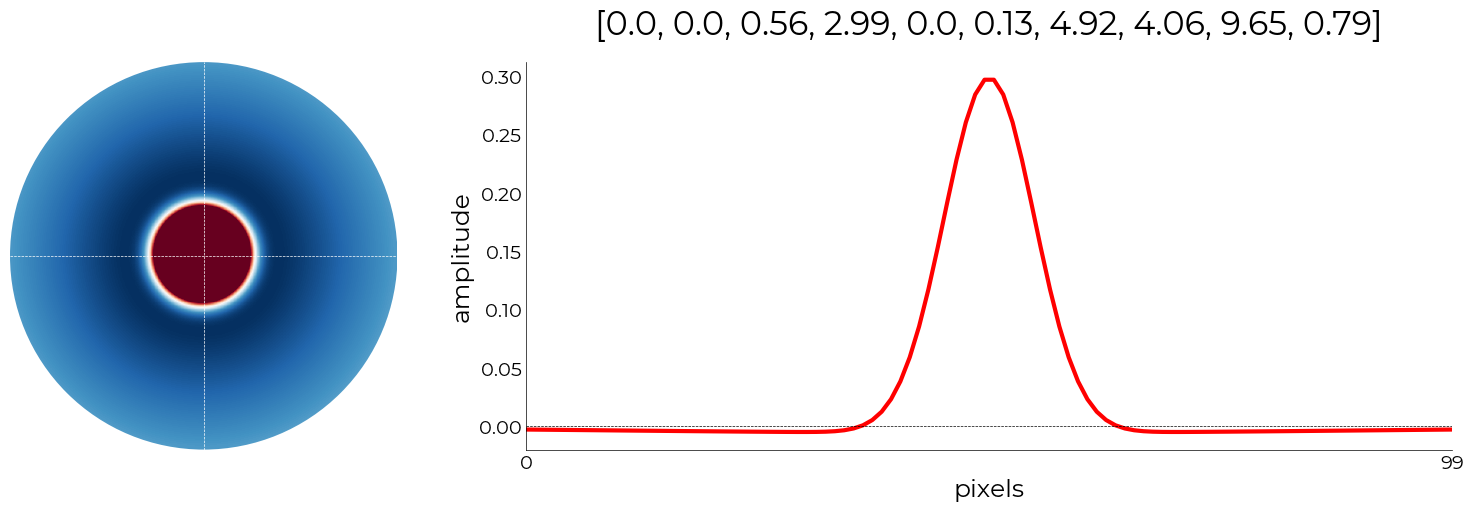

In [7]:
imp = prf.pRFmodelFitting(
    None,
    design_matrix=tiny_dm,
    TR=1.5,
    verbose=True,
    model="norm",
    hrf="direct"
)

cent_pars = pars.copy()
cent_pars[:2] = 0
imp.load_params(cent_pars, model="norm")

_,_,_,prof_1d = imp.plot_vox(vox_nr=0, title="pars", model="norm", axis_type="pixels", x_label="pixels")


In [8]:
from linescanning import fitting
met = fitting.HRFMetrics(prof_1d, TR=1).return_metrics()
met


,magnitude,magnitude_ix,fwhm,fwhm_obj,time_to_peak,half_rise_time,half_max,rise_slope,rise_slope_t,positive_area,undershoot
0,0.29977,49,11.352082,<linescanning.fitting.FWHM object at 0x7fa7501...,49,43.823959,0.149885,0.038017,44,3.591734,0.040578


In [13]:
deg = np.arange(-5,5, step=0.1)
deg.shape


(100,)

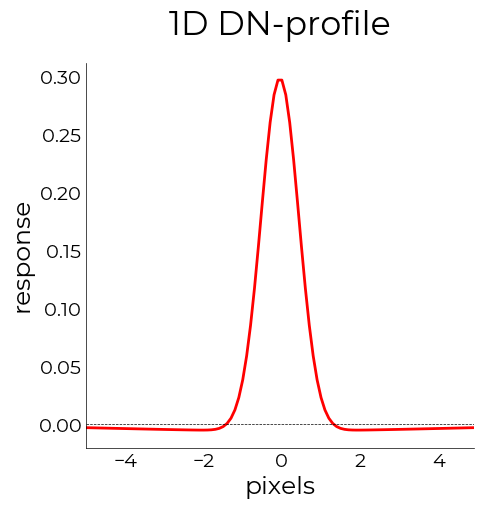

In [14]:
fig,axs = plt.subplots(figsize=(5,5))

plotting.LazyPlot(
    prof_1d,
    xx=deg,
    line_width=2,
    color="r",
    axs=axs,
    x_label="pixels",
    y_label="response",
    title="1D DN-profile",
    add_hline=0
)

size_act_size = 
fitting.fwhm_lines(
    [met.iloc[0].fwhm_obj],
    axs=axs,
    color="r"
)


In [16]:
# get size-response 
SR_ = prf.SizeResponse(params=cent_pars, model="norm")
SR_.params_df


,x,y,prf_size,prf_ampl,bold_bsl,surr_ampl,surr_size,neur_bsl,surr_bsl,A,B,C,D,ratio (B/D),r2,size ratio,suppression index,ecc,polar
0,0.0,0.0,0.558244,2.990884,0.0,0.12928,4.922754,4.057893,9.653026,2.990884,4.057893,0.12928,9.653026,0.420375,0.794895,8.818288,3.361247,0.0,0.0


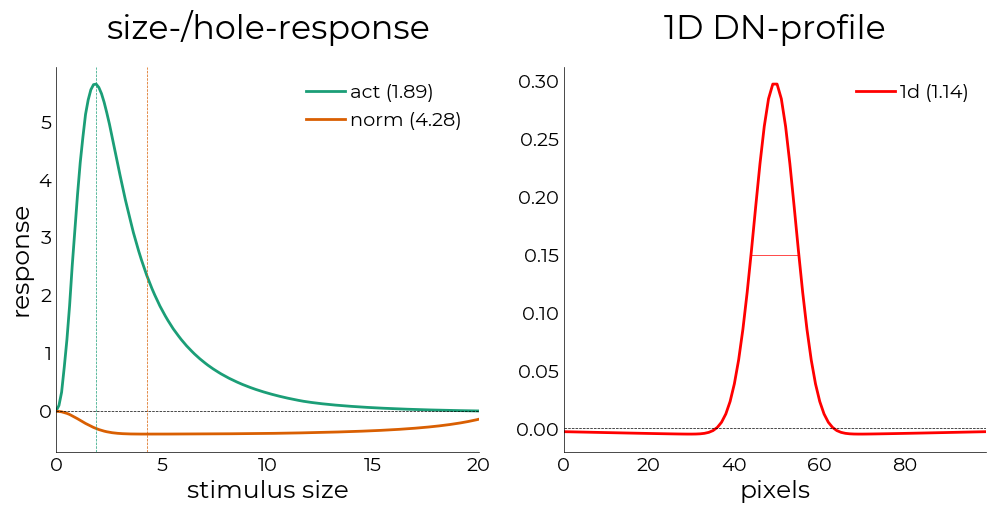

In [17]:
import pandas as pd
rf = SR_.params_df
fill_cent, fill_cent_sizes = SR_.make_stimuli(
    factor=1,
    dt="fill"
)

sr_cent_act = SR_.batch_sr_function(
    rf,
    center_prf=True,
    stims=fill_cent,
    sizes=fill_cent_sizes
)

# hole-response
hole_cent, hole_cent_sizes = SR_.make_stimuli(
    factor=1,
    dt="hole"
)

sr_cent_norm = SR_.batch_sr_function(
    rf,
    center_prf=True,
    stims=hole_cent,
    sizes=hole_cent_sizes
)

# extract size-/hole-response functions
act = sr_cent_act.iloc[:,0].values
norm = sr_cent_norm.iloc[:,0].values

# get optimal sizees
act_ix = np.where(act == act.max())[0][0]
act_stim = fill_cent_sizes[act_ix]
norm_ix = np.where(norm == norm.min())[0][0]
norm_stim = hole_cent_sizes[norm_ix]

# plot
fig,axs = plt.subplots(ncols=2, figsize=(12,5))
plotting.LazyPlot(
    [act,norm],
    xx=fill_cent_sizes,
    color=["#1B9E77","#D95F02"],
    line_width=2,
    figsize=(5,5),
    x_label="stimulus size",
    y_label="response",
    labels=[f"act ({round(act_stim,2)})",f"norm ({round(norm_stim,2)})"],
    add_hline=0,
    add_vline={
        "pos": [act_stim,norm_stim],
        "color": ["#1B9E77","#D95F02"]
    },
    axs=axs[0],
    title="size-/hole-response"
)

dx = 0.1
stim_1d = met.iloc[0]['fwhm']*dx
plotting.LazyPlot(
    prof_1d,
    line_width=2,
    color="r",
    axs=axs[1],
    x_label="pixels",
    # y_label="response",
    title="1D DN-profile",
    add_hline=0,
    labels=[f"1d ({round(stim_1d,2)})"]
)

fitting.fwhm_lines(
    met.iloc[0].fwhm_obj,
    axs[1],
    color="r",
)



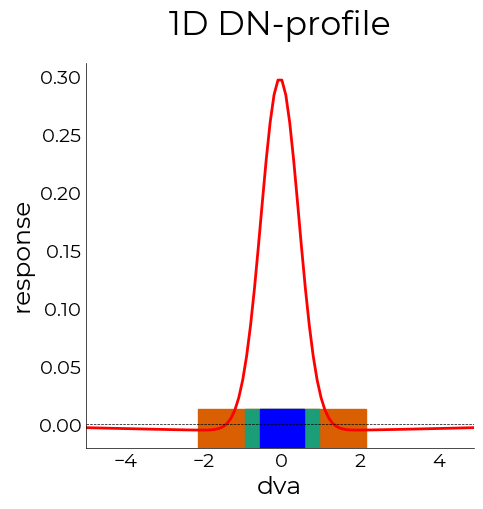

In [27]:
fig,axs = plt.subplots(figsize=(5,5))

plotting.LazyPlot(
    prof_1d,
    xx=deg,
    line_width=2,
    color="r",
    axs=axs,
    x_label="dva",
    y_label="response",
    title="1D DN-profile",
    add_hline=0
)

# axs.axvspan(0,2, ymax=0.1,alpha=0.8, color="#1B9E77")
axs.axvspan(-norm_stim/2,norm_stim/2, ymax=0.1, color="#D95F02")
axs.axvspan(-act_stim/2,act_stim/2, ymax=0.1, color="#1B9E77")
axs.axvspan(-stim_1d/2,stim_1d/2, ymax=0.1, color="b")
fitting.fwhm_lines(
    [met.iloc[0].fwhm_obj],
    axs=axs,
    color="r"
)


In [111]:
# predicted response of stimulus size derived from 1D profile from size-response curve
resp_of_1d_in_sr = act[utils.find_nearest(fill_cent_sizes, 3)[0]]
resp_of_1d_in_sr/act.max()*100


72.00965421882205

In [104]:
# find zero crossing
zeros = np.zeros_like(prof_1d)
xx = np.arange(0, zeros.shape[0])

coords = utils.find_intersection(
    xx,
    zeros,
    prof_1d
)

coords = [int(i[0][0]) for i in coords]
coords.sort()

size_zero = coords[-1]-coords[0]
size_zero


30

In [44]:
# auc_suppr = []
# for vox in range(data.shape[-1]):
#     _,_,_,pred = obj.plot_vox(vox_nr=vox, model="norm", make_figure=False)
#     pred = pred.squeeze()

#     if np.var(pred) != 0:
#         neg_tc = np.zeros_like(pred)
#         neg_tc[pred<0] = pred[pred<0]
#         auc = abs(np.trapz(neg_tc, dx=obj.TR))

#         auc_suppr.append(auc)

# auc_suppr = np.array(auc_suppr)
# auc_suppr.shape


KeyboardInterrupt: 